# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from scipy.stats import linregress
import os

# Set visual style
plt.style.use('seaborn-v0_8-whitegrid')

## Load Data & Merge

In [2]:
import pandas as pd
import numpy as np
import os

# Define the data directory
DATA_DIR = "DATA"

# ==========================================
# 1. SETUP FILE LIST
# ==========================================
file_pairs = [
    ('DEMO_1999_2000.xpt', 'NHANES_1999_2000_MORT_2019_PUBLIC.dat'),
    ('DEMO_2001_2002.xpt', 'NHANES_2001_2002_MORT_2019_PUBLIC.dat'),
    ('DEMO_2003_2004.xpt', 'NHANES_2003_2004_MORT_2019_PUBLIC.dat'),
    ('DEMO_2005_2006.xpt', 'NHANES_2005_2006_MORT_2019_PUBLIC.dat'),
    ('DEMO_2007_2008.xpt', 'NHANES_2007_2008_MORT_2019_PUBLIC.dat'),
    ('DEMO_2009_2010.xpt', 'NHANES_2009_2010_MORT_2019_PUBLIC.dat'),
    ('DEMO_2011_2012.xpt', 'NHANES_2011_2012_MORT_2019_PUBLIC.dat'),
    ('DEMO_2013_2014.xpt', 'NHANES_2013_2014_MORT_2019_PUBLIC.dat'),
    ('DEMO_2015_2016.xpt', 'NHANES_2015_2016_MORT_2019_PUBLIC.dat'),
    ('DEMO_2017_2018.xpt', 'NHANES_2017_2018_MORT_2019_PUBLIC.dat'),
]

def parse_mortality_file(filename):
    """Parses the fixed-width mortality file for any year."""
    # Build full path
    filepath = os.path.join(DATA_DIR, filename)
    
    data = []
    if not os.path.exists(filepath):
        print(f"⚠️ MISSING MORTALITY FILE: {filepath}")
        return pd.DataFrame()
        
    with open(filepath, 'r') as f:
        for line in f:
            try:
                # SEQN: Bytes 0-6
                seqn = int(line[0:6])
                # MORTSTAT: Byte 15
                mortstat = int(line[15:16])
                # PERMTH_EXM: Bytes 42-45
                permth_str = line[42:45].strip()
                permth = float(permth_str) if permth_str != '' else np.nan
                data.append([seqn, mortstat, permth])
            except:
                continue
    return pd.DataFrame(data, columns=['SEQN', 'mortstat', 'permth_exm'])

# ==========================================
# 2. LOAD & MERGE
# ==========================================
all_data = []

print(f"Starting merge of {len(file_pairs)} cycles from {DATA_DIR}/...")

for demo_file, mort_file in file_pairs:
    # Build full path for demo file
    demo_path = os.path.join(DATA_DIR, demo_file)
    
    if os.path.exists(demo_path):
        print(f"Processing {demo_file}...")
        try:
            demo = pd.read_sas(demo_path)
            demo.columns = [c.upper() for c in demo.columns] 
            
            # Use 'DMDHHSIZ' if available, otherwise just keep SEQN and Age
            cols_to_keep = ['SEQN', 'RIDAGEYR']
            if 'DMDHHSIZ' in demo.columns:
                cols_to_keep.append('DMDHHSIZ')
                
            demo = demo[cols_to_keep]
            mort = parse_mortality_file(mort_file)
            
            if not mort.empty:
                demo['SEQN'] = pd.to_numeric(demo['SEQN'], errors='coerce')
                mort['SEQN'] = pd.to_numeric(mort['SEQN'], errors='coerce')
                
                merged = pd.merge(demo, mort, on='SEQN')
                all_data.append(merged)
        except Exception as e:
            print(f"  Error reading {demo_file}: {e}")
    else:
        print(f"⚠️ MISSING DEMO FILE: {demo_path}")

if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    print(f"Merge Complete. Final record count: {len(final_df)}")
else:
    print("No data merged. Check if the 'DATA' folder contains the files.")

Starting merge of 10 cycles from DATA/...
Processing DEMO_1999_2000.xpt...
Processing DEMO_2001_2002.xpt...
Processing DEMO_2003_2004.xpt...
Processing DEMO_2005_2006.xpt...
Processing DEMO_2007_2008.xpt...
Processing DEMO_2009_2010.xpt...
Processing DEMO_2011_2012.xpt...
Processing DEMO_2013_2014.xpt...
Processing DEMO_2015_2016.xpt...
Processing DEMO_2017_2018.xpt...
Merge Complete. Final record count: 59064


## Cleanup

In [3]:
# ==========================================
# 3. CLEANUP (STRICT TYPE CONVERSION)
# ==========================================
if all_data:
    df_big = pd.concat(all_data, ignore_index=True)
    
    # 1. Remove Duplicates
    df_big = df_big.drop_duplicates(subset=['SEQN'], keep='first')
    
    # 2. STRICTLY CONVERT TYPES (Fixes the UserWarning)
    # This forces any accidental strings to become numbers (or NaN if invalid)
    df_big['mortstat'] = pd.to_numeric(df_big['mortstat'], errors='coerce')
    df_big['permth_exm'] = pd.to_numeric(df_big['permth_exm'], errors='coerce')
    df_big['RIDAGEYR'] = pd.to_numeric(df_big['RIDAGEYR'], errors='coerce')
    
    # 3. Filter Data
    df = df_big[df_big['RIDAGEYR'] >= 50].copy()
    df = df.dropna(subset=['mortstat', 'permth_exm', 'DMDHHSIZ'])
    
    # 4. Define Groups
    df['Group'] = np.where(df['DMDHHSIZ'] == 1, 'Isolated (Alone)', 'Connected (With Others)')
    
    # 5. Calculate Age at Event
    df['follow_up_years'] = df['permth_exm'] / 12.0
    df['age_at_event'] = df['RIDAGEYR'] + df['follow_up_years']
    
    print("=" * 30)
    print(f"FINAL DATASET SIZE (Age 50+): {len(df)}")
    print(df['Group'].value_counts())
    
    # Sanity Check: If max age is > 125, we still have a bug.
    print(f"Max Age in Data: {df['age_at_event'].max():.1f}")
else:
    print("Error: No data loaded.")


FINAL DATASET SIZE (Age 50+): 27139
Group
Connected (With Others)    21014
Isolated (Alone)            6125
Name: count, dtype: int64
Max Age in Data: 105.7


# Analysis Part A - Survival Curves

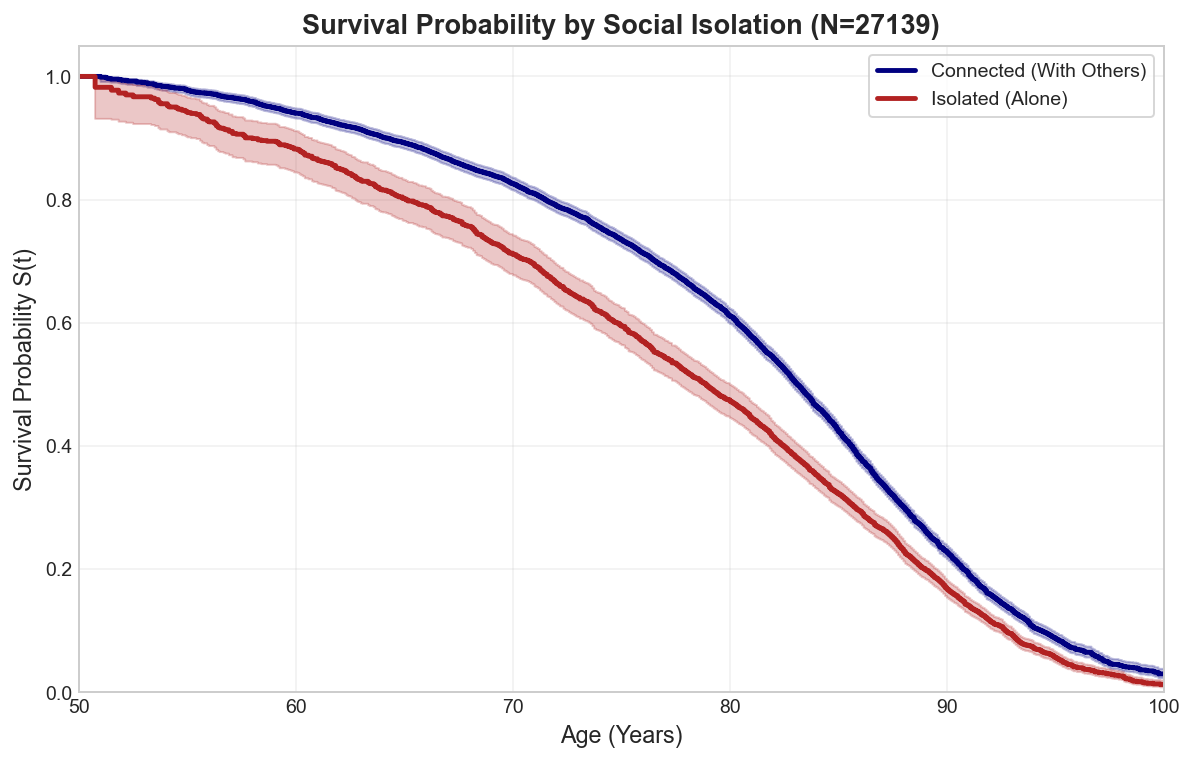

In [4]:
plt.figure(figsize=(10, 6), dpi=140)
kmf = KaplanMeierFitter()

# --- FIX: Use the EXACT strings from your dataframe column 'Group' ---
groups = ['Connected (With Others)', 'Isolated (Alone)']

# Update colors dictionary to match these exact keys
colors = {
    'Isolated (Alone)': 'firebrick', 
    'Connected (With Others)': 'navy'
}

plt.xlim(50, 100)

for group in groups:
    mask = df['Group'] == group
    
    # Check if we actually found data (Good debugging practice)
    if mask.sum() == 0:
        print(f"Warning: No data found for group '{group}'")
        continue

    kmf.fit(
        durations=df.loc[mask, 'age_at_event'], 
        event_observed=df.loc[mask, 'mortstat'], 
        entry=df.loc[mask, 'RIDAGEYR'],   
        label=group  # The group name is already descriptive
    )
    
    kmf.plot_survival_function(color=colors[group], linewidth=2.5)

plt.title(f'Survival Probability by Social Isolation (N={len(df)})', fontsize=14, fontweight='bold')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Survival Probability S(t)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.legend(frameon=True)
plt.savefig('fig1.png')
plt.show()

# Gender seperation

In [5]:
# Define the folder where your files live
DATA_DIR = "DATA"

def parse_mortality_file(filename):
    """Parses the fixed-width mortality file with correct folder path."""
    # UPDATE: Point to DATA folder
    filepath = os.path.join(DATA_DIR, filename)
    
    data = []
    if not os.path.exists(filepath):
        print(f"⚠️ MISSING MORTALITY: {filepath}")
        return pd.DataFrame()
        
    with open(filepath, 'r') as f:
        for line in f:
            try:
                seqn = int(line[0:6])
                mortstat = int(line[15:16])
                permth_str = line[42:45].strip() 
                permth = float(permth_str) if permth_str != '' else np.nan
                data.append([seqn, mortstat, permth])
            except:
                continue
    return pd.DataFrame(data, columns=['SEQN', 'mortstat', 'permth_exm'])

# ==========================================
# 2. LOAD & MERGE (Path-Aware & Gender Fix)
# ==========================================
all_data = []

for demo_file, mort_file in file_pairs:
    # UPDATE: Point to DATA folder
    demo_path = os.path.join(DATA_DIR, demo_file)
    
    if os.path.exists(demo_path):
        try:
            demo = pd.read_sas(demo_path)
            demo.columns = [c.upper() for c in demo.columns] 
            
            # Check for necessary columns
            required_cols = ['SEQN', 'RIDAGEYR', 'DMDHHSIZ', 'RIAGENDR']
            if all(col in demo.columns for col in required_cols):
                demo = demo[required_cols]
                mort = parse_mortality_file(mort_file)
                
                if not mort.empty:
                    # Type safety
                    demo['SEQN'] = pd.to_numeric(demo['SEQN'], errors='coerce')
                    mort['SEQN'] = pd.to_numeric(mort['SEQN'], errors='coerce')
                    
                    merged = pd.merge(demo, mort, on='SEQN')
                    all_data.append(merged)
        except Exception as e:
            print(f"Error processing {demo_file}: {e}")

if all_data:
    df_big = pd.concat(all_data, ignore_index=True)
    df_big = df_big.drop_duplicates(subset=['SEQN'], keep='first')
    
    # Strict Type Conversion
    cols = ['mortstat', 'permth_exm', 'RIDAGEYR', 'RIAGENDR', 'DMDHHSIZ']
    for c in cols:
        df_big[c] = pd.to_numeric(df_big[c], errors='coerce')
        
    # Filter Age and drop NaNs
    df = df_big[df_big['RIDAGEYR'] >= 50].copy()
    df = df.dropna(subset=cols)
    
    # Define Groups
    df['Group'] = np.where(df['DMDHHSIZ'] == 1, 'Isolated', 'Connected')
    
    # Decode Gender (1=Male, 2=Female)
    df['Gender'] = df['RIAGENDR'].map({1: 'Male', 2: 'Female'})
    
    # Calc Age at Event
    df['follow_up_years'] = df['permth_exm'] / 12.0
    df['age_at_event'] = df['RIDAGEYR'] + df['follow_up_years']
    
    print("Merge and Cleaning Complete.")
    print(f"Final Total N: {len(df)}")
    print("-" * 30)
    print(df.groupby(['Gender', 'Group']).size())
else:
    print("No data was merged. Double-check your DATA folder paths.")

Merge and Cleaning Complete.
Final Total N: 27139
------------------------------
Gender  Group    
Female  Connected    10129
        Isolated      3677
Male    Connected    10885
        Isolated      2448
dtype: int64


## Clean & Define Groups

In [6]:
if all_data:
    df_big = pd.concat(all_data, ignore_index=True)
    df_big = df_big.drop_duplicates(subset=['SEQN'], keep='first')
    
    # Strict Type Conversion
    cols = ['mortstat', 'permth_exm', 'RIDAGEYR', 'RIAGENDR', 'DMDHHSIZ']
    for c in cols:
        df_big[c] = pd.to_numeric(df_big[c], errors='coerce')
        
    # Filter
    df = df_big[df_big['RIDAGEYR'] >= 50].copy()
    df = df.dropna(subset=cols)
    
    # Define Groups
    df['Group'] = np.where(df['DMDHHSIZ'] == 1, 'Isolated', 'Connected')
    
    # Decode Gender (1=Male, 2=Female in NHANES)
    df['Gender'] = df['RIAGENDR'].map({1: 'Male', 2: 'Female'})
    
    # Calc Age at Event
    df['follow_up_years'] = df['permth_exm'] / 12.0
    df['age_at_event'] = df['RIDAGEYR'] + df['follow_up_years']
    
    print(f"Total N: {len(df)}")
    print(df.groupby(['Gender', 'Group']).size())

Total N: 27139
Gender  Group    
Female  Connected    10129
        Isolated      3677
Male    Connected    10885
        Isolated      2448
dtype: int64


## The "Truth" Plot (Split by Sex)

<Figure size 1200x600 with 0 Axes>

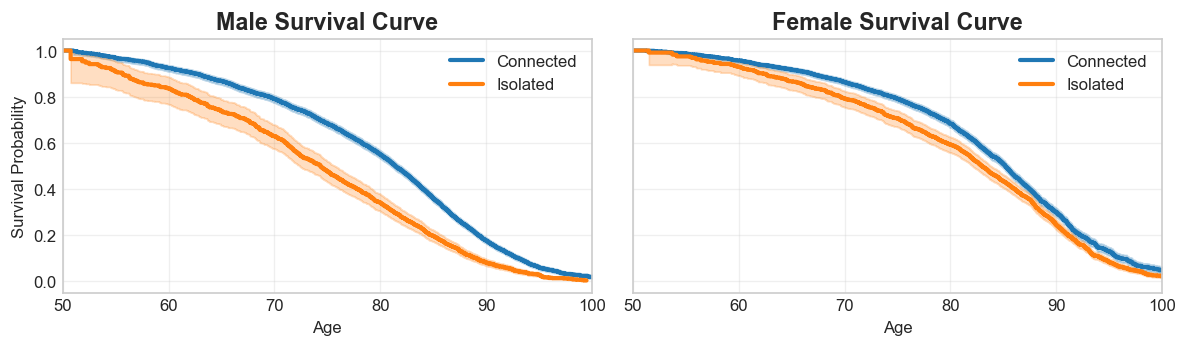

In [7]:
# ==========================================
# 4. SURVIVAL ANALYSIS (CORRECTED FOR LEFT TRUNCATION)
# ==========================================

plt.figure(figsize=(12, 6))
kmf = KaplanMeierFitter()

# Two subplots: Male vs Female
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 3), dpi=120)

for i, gender in enumerate(['Male', 'Female']):
    ax = axes[i]
    df_g = df[df['Gender'] == gender]
    
    for group in ['Connected', 'Isolated']:
        mask = df_g['Group'] == group
        
        # --- THE FIX IS HERE ---
        # entry: When they entered the study (RIDAGEYR)
        # durations: When they died/censored (age_at_event)
        kmf.fit(durations=df_g.loc[mask, 'age_at_event'], 
                event_observed=df_g.loc[mask, 'mortstat'], 
                entry=df_g.loc[mask, 'RIDAGEYR'], # <--- CRITICAL FIX
                label=group)
        
        kmf.plot_survival_function(ax=ax, linewidth=2.5)

    ax.set_title(f'{gender} Survival Curve', fontsize=14, fontweight='bold')
    ax.set_xlabel('Age')
    if i == 0: ax.set_ylabel('Survival Probability')
    ax.set_xlim(50, 100)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig2.png')
plt.show()

<Figure size 1400x600 with 0 Axes>

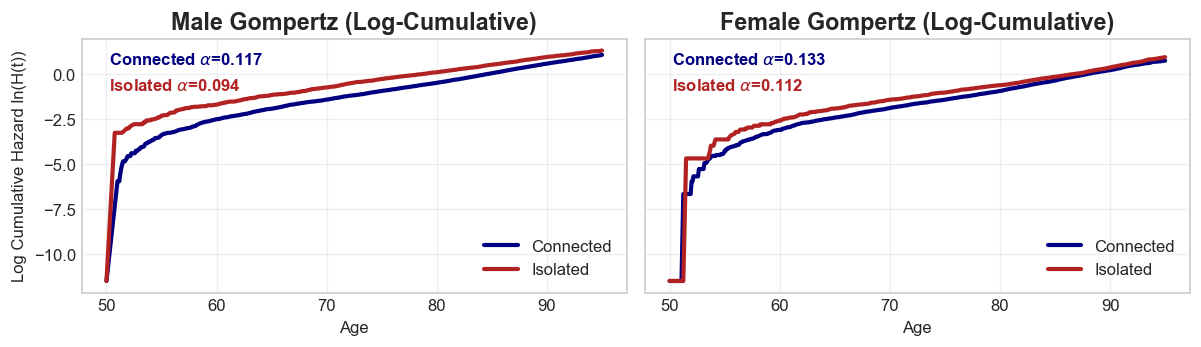

In [8]:
# ==========================================
# 5. GOMPERTZ ANALYSIS (CORRECTED)
# ==========================================
# We check the Log-Cumulative Hazard again with the fix

plt.figure(figsize=(14, 6))
naf = NelsonAalenFitter()
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=120, sharey=True)

start_age, end_age = 50, 95

for i, gender in enumerate(['Male', 'Female']):
    ax = axes[i]
    df_g = df[df['Gender'] == gender]
    
    for group in ['Connected', 'Isolated']:
        mask = df_g['Group'] == group
        color = 'firebrick' if group == 'Isolated' else 'navy'
        
        # --- THE FIX IS HERE TOO ---
        naf.fit(durations=df_g.loc[mask, 'age_at_event'], 
                event_observed=df_g.loc[mask, 'mortstat'],
                entry=df_g.loc[mask, 'RIDAGEYR'], # <--- CRITICAL FIX
                label=group)
        
        # Get H(t) and log-transform
        H_t = naf.cumulative_hazard_
        # Slice to relevant age range
        H_t = H_t.loc[start_age:end_age]
        log_H_t = np.log(H_t + 1e-5)
        
        # Plot
        ax.plot(log_H_t.index, log_H_t.values, color=color, label=group, linewidth=2.5)
        
        # Calculate Slope (Alpha)
        if len(log_H_t) > 10:
            x = log_H_t.index.values
            y = log_H_t.iloc[:, 0].values
            slope, intercept, _, _, _ = linregress(x, y)
            ax.text(0.05, 0.9 - (0.1 if group=='Isolated' else 0), 
                    f"{group} $\\alpha$={slope:.3f}", 
                    transform=ax.transAxes, color=color, fontweight='bold')

    ax.set_title(f'{gender} Gompertz (Log-Cumulative)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Age')
    if i == 0: ax.set_ylabel('Log Cumulative Hazard ln(H(t))')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig3.png')
plt.show()

## The "Survivor Bias" Proof (Boxplot)

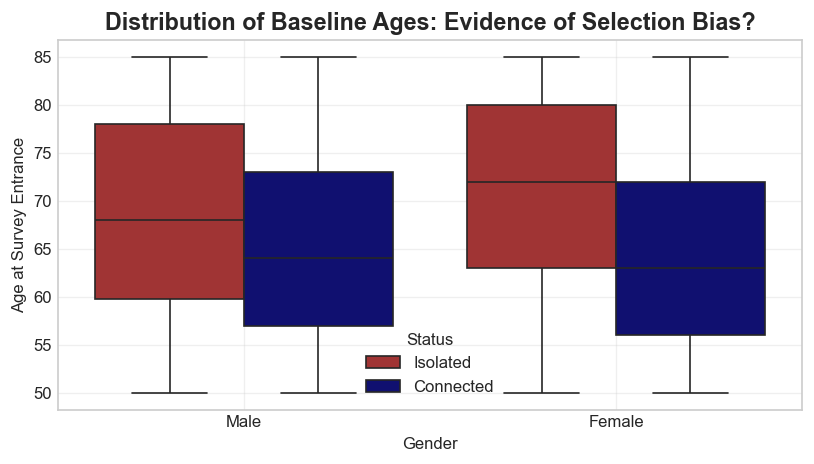

Gender  Group    
Female  Connected    64.458880
        Isolated     70.804460
Male    Connected    65.401562
        Isolated     67.868056
Name: RIDAGEYR, dtype: float64


In [9]:
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=120)
# Boxplot of Age Distribution by Group and Gender
sns.boxplot(data=df, x='Gender', y='RIDAGEYR', hue='Group', 
            palette={'Isolated': 'firebrick', 'Connected': 'navy'})

plt.title('Distribution of Baseline Ages: Evidence of Selection Bias?', fontsize=14, fontweight='bold')
plt.ylabel('Age at Survey Entrance')
plt.grid(True, alpha=0.3)
plt.legend(title='Status')
plt.savefig('fig4.png')
plt.show()

# Print mean ages to confirm
print(df.groupby(['Gender', 'Group'])['RIDAGEYR'].mean())